# Imports et chargement des données

In [141]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score #, precision_recall_curve, , average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [3]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [4]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

# Exploration

In [5]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [6]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
285122,430215,0,Cash loans,M,Y,Y,0,153000.0,315000.0,16623.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
153799,278250,0,Cash loans,M,Y,Y,1,135000.0,450000.0,27324.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
263106,404663,0,Cash loans,M,N,N,0,202500.0,780363.0,33192.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
263702,405321,0,Cash loans,F,N,N,0,221400.0,247500.0,9814.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
77459,189811,1,Cash loans,F,N,Y,1,157500.0,808650.0,31464.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
101522,217872,0,Cash loans,F,N,Y,0,202500.0,618183.0,26320.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0
169700,296677,1,Cash loans,F,N,Y,0,180000.0,916470.0,26793.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
41356,147883,0,Cash loans,M,N,Y,0,112500.0,227520.0,14940.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
278418,422589,0,Cash loans,F,Y,N,0,112500.0,781920.0,28084.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
94979,210288,1,Cash loans,M,N,N,0,90000.0,284400.0,20740.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [7]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [8]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [9]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [10]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [11]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
23527,271038,Cash loans,F,N,Y,0,220500.0,858622.5,27828.0,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
42877,412641,Cash loans,F,Y,Y,2,157500.0,1706400.0,53095.5,1350000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
41777,406100,Cash loans,F,N,Y,0,225000.0,360000.0,15133.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3531,124938,Cash loans,F,N,Y,0,157500.0,245268.0,17977.5,202500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
37069,371193,Cash loans,F,N,N,0,67500.0,598500.0,19435.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
14191,202410,Cash loans,F,N,Y,0,67500.0,675000.0,27229.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
38945,386832,Cash loans,F,N,Y,0,171000.0,237024.0,13734.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
28178,305562,Cash loans,F,N,Y,0,126000.0,536917.5,27544.5,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
29651,315813,Cash loans,M,N,Y,0,315000.0,1024740.0,52452.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
36921,370203,Cash loans,M,Y,Y,1,337500.0,360000.0,23134.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0


In [12]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1027634,276964,5889444,Closed,currency 1,-1166,0,-922.0,-922.0,NaN,0,107505.0,0.0,0.0,0.0,Consumer credit,-870,0.000
1108587,163301,6181731,Active,currency 1,-417,0,313.0,NaN,NaN,0,530622.0,290614.5,0.0,0.0,Consumer credit,-16,NaN
242245,360574,5794385,Closed,currency 1,-1698,0,-1152.0,-1145.0,NaN,0,60804.0,0.0,0.0,0.0,Consumer credit,-1142,NaN
834734,316603,6637381,Active,currency 1,-1294,0,533.0,NaN,NaN,0,1483650.0,582358.5,0.0,0.0,Consumer credit,-12,0.000
1466236,105224,6758646,Closed,currency 1,-1904,0,-1812.0,-1813.0,NaN,0,36000.0,0.0,0.0,0.0,Consumer credit,-1693,13087.485
935637,389120,5445382,Active,currency 1,-159,0,1667.0,NaN,NaN,0,234000.0,227034.0,0.0,0.0,Consumer credit,-54,NaN
981631,104836,6213658,Closed,currency 1,-935,0,-754.0,-700.0,NaN,0,29533.5,NaN,NaN,0.0,Consumer credit,-697,NaN
7217,143950,5723165,Closed,currency 1,-1409,0,-1043.0,-1043.0,6733.575,0,78525.0,0.0,0.0,0.0,Consumer credit,-1043,NaN
582833,197940,6449562,Closed,currency 1,-1501,0,-1318.0,-1318.0,NaN,0,28147.5,0.0,NaN,0.0,Consumer credit,-1173,NaN
505797,254507,6534169,Closed,currency 1,-726,0,-514.0,-542.0,0.000,0,77814.0,0.0,0.0,0.0,Consumer credit,-542,NaN


In [13]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [14]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [15]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [16]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [17]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [18]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [19]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [20]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [21]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [22]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
95441,1211171,141441,-6,0.000,0,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,80.0,Active,0,0
2010244,1617452,325244,-22,176861.025,180000,135000.0,135000.00,0.0,0.0,9000.00,...,176861.025,176861.025,6.0,6,0.0,0.0,53.0,Active,0,0
501505,1691940,351775,-25,0.000,0,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0
1854951,2126775,235539,-23,0.000,90000,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,32.0,Active,0,0
1416720,2257505,179280,-5,0.000,9000,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,3.0,Active,0,0
691637,2801443,431273,-9,19162.350,45000,0.0,0.00,0.0,0.0,2250.00,...,19162.350,19162.350,0.0,0,0.0,0.0,70.0,Active,0,0
3598944,2622088,211375,-41,23593.050,45000,0.0,0.00,0.0,0.0,2250.00,...,23593.050,23593.050,0.0,0,0.0,0.0,12.0,Active,0,0
2137458,2789324,392924,-6,0.000,180000,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,60.0,Active,0,0
2564627,1229564,363971,-2,180173.610,202500,60750.0,60750.00,0.0,0.0,6349.32,...,176362.110,176362.110,2.0,2,0.0,0.0,4.0,Active,0,0
2890425,1446331,371248,-9,41.490,0,0.0,41.49,0.0,0.0,1476.00,...,41.490,41.490,0.0,0,0.0,0.0,12.0,Completed,0,0


In [23]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [24]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1502814,2276701,286693,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,13,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
257774,1171055,317045,Consumer loans,4691.205,22815.0,22815.0,0.0,22815.0,MONDAY,14,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-4.0,146.0,365243.0,365243.0,0.0
1010018,2247149,172000,Consumer loans,24837.210,111600.0,92421.0,22320.0,111600.0,SATURDAY,13,...,Furniture,4.0,middle,POS industry with interest,365243.0,-862.0,-772.0,-832.0,-827.0,0.0
1244746,2381126,132539,Cash loans,30428.730,1129500.0,1129500.0,NaN,1129500.0,FRIDAY,10,...,XNA,60.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1183449,1625456,354650,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,14,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1342953,2247465,427940,Revolving loans,11250.000,225000.0,225000.0,NaN,225000.0,WEDNESDAY,11,...,XNA,0.0,XNA,Card Street,-622.0,-578.0,365243.0,365243.0,365243.0,0.0
923198,2544196,292184,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
537029,2799031,164144,Revolving loans,6750.000,135000.0,135000.0,NaN,135000.0,TUESDAY,11,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
559598,1882618,415406,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,16,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
238903,2249694,417759,Consumer loans,4553.595,39451.5,39019.5,3946.5,39451.5,MONDAY,9,...,Connectivity,12.0,low_normal,POS mobile with interest,365243.0,-2674.0,-2344.0,-2344.0,-2335.0,1.0


In [25]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [26]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [27]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13076932,2106236,443472,1.0,12,-2106.0,-2137.0,7793.550,38.385
514837,2505337,168361,0.0,82,-1185.0,-1186.0,2250.000,2250.000
11386025,1440100,341093,1.0,10,-309.0,-312.0,4054.275,4054.275
390249,1576526,129420,1.0,3,-1196.0,-1198.0,18937.215,18937.215
7163407,1772344,253542,0.0,86,-10.0,-16.0,13500.000,13500.000
317286,1820308,122413,1.0,3,-2903.0,-2903.0,15105.330,15105.330
6065586,1920783,284739,0.0,9,-213.0,-224.0,2250.000,2250.000
971983,2206420,108145,0.0,35,-2577.0,-2577.0,182.790,182.790
9222001,1721335,385952,1.0,4,-326.0,-326.0,22680.045,22680.045
7946649,2074663,338391,1.0,2,-623.0,-630.0,44384.715,44384.715


In [28]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [29]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [30]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms - datascientist\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [31]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [32]:
# suppression des colonnes qui sont en fait des indexes
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

## Analyse du résultat

In [33]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [34]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [35]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [36]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
199083,0,1,0,1,0,63000.0,312768.0,13378.5,270000.0,0,...,NaN,NaN,NaN,NaN,1.000000,10.754717,-523.452830,-528.867925,12157.352830,11933.708774
248017,0,0,0,0,0,238500.0,625536.0,20803.5,540000.0,1,...,NaN,NaN,NaN,NaN,1.000000,14.000000,-393.000000,-418.777778,25679.520000,25679.520000
145345,0,1,1,0,1,90000.0,484789.5,25510.5,418500.0,0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-97.000000,-189.000000,4901.130000,4901.130000
47773,0,1,1,0,1,225000.0,1436850.0,42142.5,1125000.0,1,...,NaN,NaN,NaN,NaN,1.026316,6.236842,-1008.842105,-1020.447368,11061.358816,9288.320921
208684,0,1,0,0,0,103500.0,454500.0,17784.0,454500.0,0,...,0.0,0.0,0.0,0.0,0.107914,58.215827,-1616.697842,-1621.338129,7510.507446,7505.586906
182649,0,0,1,0,0,157500.0,1086426.0,46161.0,931500.0,1,...,0.0,0.0,0.0,0.0,0.686567,7.179104,-1230.805970,-1242.940299,5722.731940,5720.922537
262369,0,0,1,0,0,180000.0,482593.5,32251.5,436500.0,1,...,NaN,NaN,NaN,NaN,1.000000,6.500000,-2670.000000,-2676.750000,6453.971250,6453.971250
106558,0,0,1,0,0,135000.0,794173.5,43213.5,697500.0,1,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-672.000000,-724.285714,21652.675714,21652.675714
212459,0,0,0,1,0,225000.0,746280.0,58963.5,675000.0,0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
283998,0,0,1,1,0,292500.0,548770.5,26527.5,490500.0,2,...,0.0,0.0,0.0,0.0,2.581818,12.109091,-657.563636,-672.818182,43496.861727,50241.478091


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [37]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIMARY                302902
RATE_INTEREST_PRIVILEGED             302902
cc_bal_AMT_PAYMENT_CURRENT           246451
cc_bal_AMT_DRAWINGS_OTHER_CURRENT    246371
cc_bal_CNT_DRAWINGS_ATM_CURRENT      246371
                                      ...  
HOUSETYPE_MODE                            0
REG_CITY_NOT_LIVE_CITY                    0
LIVE_REGION_NOT_WORK_REGION               0
REG_REGION_NOT_WORK_REGION                0
NAME_CONTRACT_TYPE                        0
Length: 374, dtype: int64

In [38]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     315
False     59
dtype: int64

In [39]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [40]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    306
True      68
dtype: int64

In [41]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [42]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

## LGBMClassifier

### 1ière approche

In [144]:
%%time
print(f"Heure de début : {str(datetime.now())}")

clf = LGBMClassifier(n_estimators=100)
# params = {"n_estimators" : range(100, 500, 100), "learning_rate" : np.arange(0.05, 0.13, 0.01)}
params = {"learning_rate" : np.logspace(-3, 2, 6), "class_weight":[None, "balanced"]}

model_cv=GridSearchCV(clf, params, cv=5, scoring='roc_auc', verbose=10)
model_cv.fit(X_train, y_train)

Heure de début : 2020-04-11 19:27:29.495117
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=None, learning_rate=0.001, score=0.717, total=   8.1s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.8s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.711, total=   7.8s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.6s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.710, total=   8.1s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.6s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   8.1s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   47.8s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   8.2s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   56.0s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   8.2s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.739, total=   8.2s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   8.4s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.776, total=   7.3s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   7.4s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.766, total=   7.6s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   7.7s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.771, total=   7.2s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV]  class_weight=None, learning_rate=1.0, score=0.720, total=   5.2s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.2min finished


Wall time: 6min 22s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                         'learnin

In [145]:
print("best score : ", model_cv.best_score_)
print("best params_ : ", model_cv.best_params_)

best score :  0.7738448640709108
best params_ :  {'class_weight': 'balanced', 'learning_rate': 0.1}


In [146]:
%%time
clf = LGBMClassifier(n_estimators=100, learning_rate=model_cv.best_params_["learning_rate"], 
                     class_weight=model_cv.best_params_["class_weight"])
clf.fit(X_train, y_train)

Wall time: 8.97 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [147]:
ret = clf.predict_proba(X_test)
roc_auc_score(y_test, ret[:,1])

0.7776865131370082

In [148]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc_test =  auc(fpr, tpr)
auc_test

0.7805974443349991

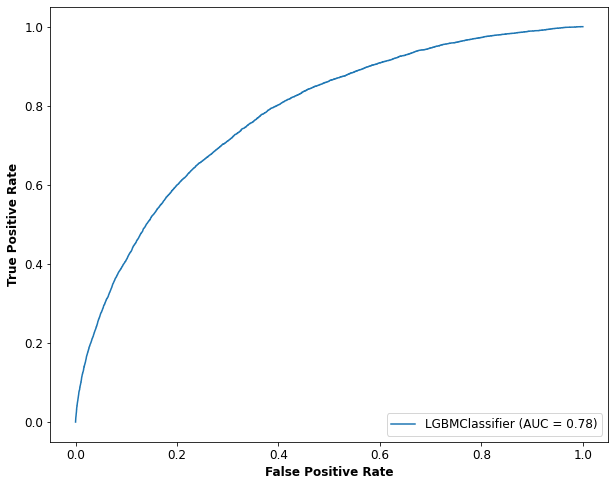

In [149]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                         "figure.figsize":[10,8], "savefig.bbox":"tight"})
plot_roc_curve(clf, X_test, y_test)
plt.show()

In [150]:
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = data.columns
df_feature_importance["occurences"] = clf.feature_importances_
df_feature_importance

,feature,occurences
0,NAME_CONTRACT_TYPE,19
1,CODE_GENDER,35
2,FLAG_OWN_CAR,0
3,FLAG_OWN_REALTY,1
4,CNT_CHILDREN,0
...,...,...
369,inst_NUM_INSTALMENT_NUMBER,22
370,inst_DAYS_INSTALMENT,7
371,inst_DAYS_ENTRY_PAYMENT,16
372,inst_AMT_INSTALMENT,4


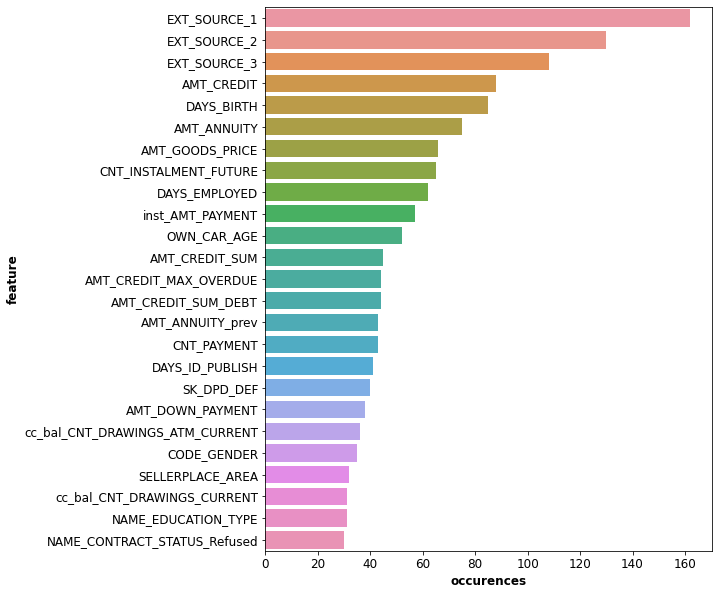

In [151]:
plt.figure(figsize=(8,10))
sns.barplot(x="occurences", y="feature", 
            data=df_feature_importance.sort_values(by="occurences", ascending=False)[:25])
plt.show()

In [152]:
df_homecredit[df_homecredit["Row"].isin(["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"])].sort_values(by="Row")

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
10,13,application_{train|test}.csv,AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN


In [153]:
df_feature_importance.sort_values(by="occurences", ascending=False)[:25]

,feature,occurences
39,EXT_SOURCE_1,162
40,EXT_SOURCE_2,130
41,EXT_SOURCE_3,108
6,AMT_CREDIT,88
15,DAYS_BIRTH,85
7,AMT_ANNUITY,75
8,AMT_GOODS_PRICE,66
329,CNT_INSTALMENT_FUTURE,65
16,DAYS_EMPLOYED,62
373,inst_AMT_PAYMENT,57


In [154]:
del clf
gc.collect()

25037

### Modification des paramètres

In [183]:
%%time
print(f"Heure de début : {str(datetime.now())}")

lgbm_train = lgbm.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=categorical_feats,
#                          free_raw_data=False
                         )
lgbm_valid = lgbm.Dataset(data=X_test,
                          label=y_test,
                         )
#‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest.
# for boost in ["gbdt", "dart", "goss"]:
#     print(boost)
# for drop in np.linspace(0.02, 0.04, 5):
#     print(drop)
lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced'
}

    cv_results = lgbm.cv(train_set=lgbm_train,
                         params=lgbm_params,
                         nfold=5,
                         num_boost_round=800,
#                          early_stopping_rounds=100,
                         verbose_eval=100,
                         metrics=['auc'])

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-11 20:26:46.603387
0.02
[100]	cv_agg's auc: 0.773088 + 0.00255023
[200]	cv_agg's auc: 0.775635 + 0.00225597
[300]	cv_agg's auc: 0.776989 + 0.00206449
[400]	cv_agg's auc: 0.777455 + 0.00216721
[500]	cv_agg's auc: 0.777691 + 0.00255026
[600]	cv_agg's auc: 0.778041 + 0.00246902
[700]	cv_agg's auc: 0.777825 + 0.0024079
[800]	cv_agg's auc: 0.777157 + 0.00246348
Optimum boost rounds = 603
Best CV result = 0.7780798311510145
0.025
[100]	cv_agg's auc: 0.772456 + 0.00320206
[200]	cv_agg's auc: 0.775227 + 0.00288794
[300]	cv_agg's auc: 0.77709 + 0.00324927
[400]	cv_agg's auc: 0.777783 + 0.003206
[500]	cv_agg's auc: 0.778136 + 0.00269442
[600]	cv_agg's auc: 0.778332 + 0.00281982
[700]	cv_agg's auc: 0.778255 + 0.00294485
[800]	cv_agg's auc: 0.778398 + 0.00289406
Optimum boost rounds = 756
Best CV result = 0.7785181457020898
0.03
[100]	cv_agg's auc: 0.771024 + 0.00244353
[200]	cv_agg's auc: 0.774172 + 0.00307985
[300]	cv_agg's auc: 0.776454 + 0.00309466
[400]	cv_agg's auc: 

In [177]:
np.log10(0.035)

-1.4559319556497243

Wall time: 24.1 s


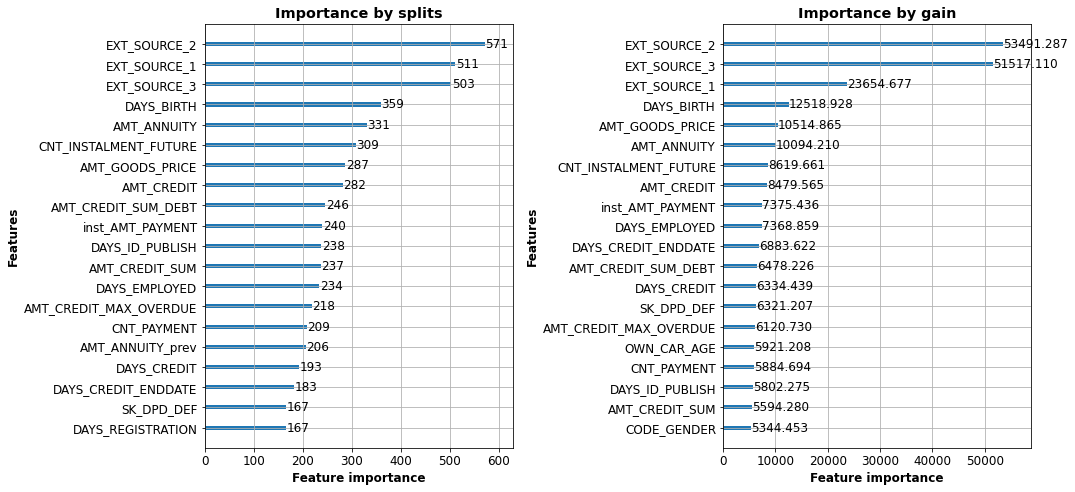

In [160]:
%%time
evals_result = {}
""" Predict on test set and create submission """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                 num_boost_round=optimum_boost_rounds)
y_pred = clf.predict(X_test)
# out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
# out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [161]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc_test =  auc(fpr, tpr)
auc_test

0.7806020179843547

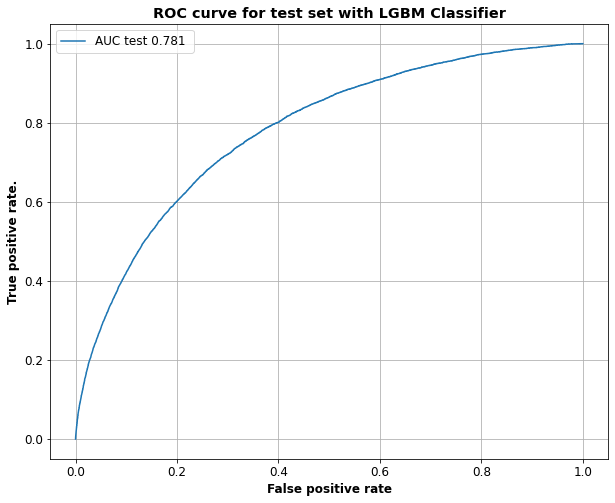

In [158]:
fpr, tpr, th = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC test {auc_test:.3f} ")
plt.legend()
plt.ylabel('True positive rate.')
plt.xlabel('False positive rate')
plt.grid()
plt.title ("ROC curve for test set with LGBM Classifier")
plt.show()


### Reprise du meilleur modèle et calcul de l'importance des features

## Suppression des valeurs nulles

In [ ]:
values = dict(data.mean())
values

In [ ]:
data2 = data.fillna(value=values)

In [ ]:
# On recalcule les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.33, random_state=42)

## SGDClassifier

In [ ]:
%%time
print(f"Heure de début : {str(datetime.now())}")

sgdc = SGDClassifier(loss="modified_huber")
params = {"alpha" : np.logspace(-4, 1, 6), "class_weight":[None, "balanced"]}

model_cv=GridSearchCV(sgdc, params, cv=5, verbose=10)
model_cv.fit(X_train, y_train)

In [ ]:
print("best score : ", model_cv.best_score_)
print("best params_ : ", model_cv.best_params_)

In [ ]:
sgdc = SGDClassifier(loss="modified_huber", alpha=model_cv.best_params_["alpha"], 
                     class_weight=model_cv.best_params_["class_weight"])
sgdc.fit(X_train, y_train)

In [ ]:
ret = sgdc.predict_proba(X_test)
roc_auc_score(y_test, ret[:,1])

In [ ]:
plot_roc_curve(sgdc, X_test, y_test)
plt.show()

## Random Forest Classifier

In [ ]:
# %%time
# # Long, environ 14 min par fold pour 1100 estimateurs (1.3 min pour 100 estimateurs) = 1h15 pour les 5 folds avec 
# # 1100 estimateurs, env 2h15 en tout
# print(f"Heure de début : {str(datetime.now())}")

# rfc = RandomForestClassifier()
# params = {"n_estimators": range(100, 1200, 500), "class_weight": ["balanced"]}

# model_cv=GridSearchCV(rfc, params, cv=5, scoring='roc_auc', verbose=10)
# model_cv.fit(X_train, y_train)

In [ ]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# print("best score : ", model_cv.best_score_)
# print("best params_ : ", model_cv.best_params_)
# rfc = RandomForestClassifier(n_estimators=model_cv.best_params_["n_estimators"], 
#                              class_weight=model_cv.best_params_["class_weight"])
# rfc.fit(X_train, y_train)

best score :  0.751986168786994
best params_ :  {'class_weight': 'balanced', 'n_estimators': 1100}

In [ ]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# ret = rfc.predict_proba(X_test)
# print(roc_auc_score(y_test, ret[:,1]))
# plot_roc_curve(rfc, X_test, y_test)
# plt.show()

AUC = 0.7543927592802018

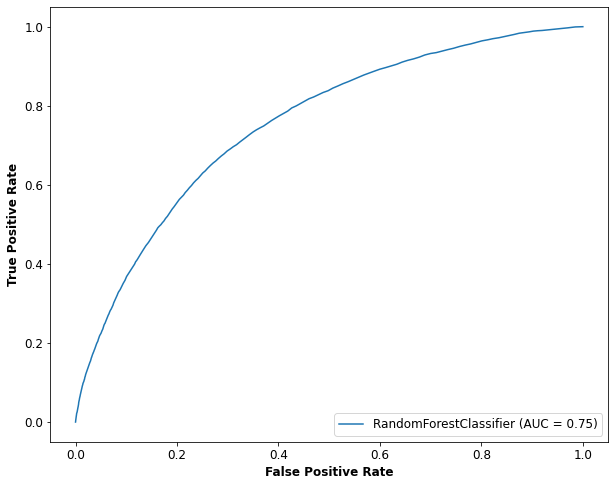

## Gradient Boosting

In [ ]:
%%time
print(f"Heure de début : {str(datetime.now())}")

gbc = GradientBoostingClassifier()
params = {"learning_rate": np.logspace(-2, 1, 4)}

model_cv=GridSearchCV(gbc, params, cv=5, scoring='roc_auc', verbose=10)
model_cv.fit(X_train, y_train)

In [ ]:
%%time
print(f"Heure de début : {str(datetime.now())}")

print("best score : ", model_cv.best_score_)
print("best params_ : ", model_cv.best_params_)
gbc = GradientBoostingClassifier(learning_rate=model_cv.best_params_["learning_rate"])
gbc.fit(X_train, y_train)

In [ ]:
%%time
print(f"Heure de début : {str(datetime.now())}")

ret = gbc.predict_proba(X_test)
print(roc_auc_score(y_test, ret[:,1]))
plot_roc_curve(gbc, X_test, y_test)
plt.show()